<a href="https://colab.research.google.com/github/KChopde/lstm-text-generator/blob/main/RNN_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Epoch 1/20, Loss: 7.2744
Epoch 2/20, Loss: 6.6932
Epoch 3/20, Loss: 6.3679
Epoch 4/20, Loss: 6.0796
Epoch 5/20, Loss: 5.8063
Epoch 6/20, Loss: 5.5413
Epoch 7/20, Loss: 5.2857
Epoch 8/20, Loss: 5.0469
Epoch 9/20, Loss: 4.8262
Epoch 10/20, Loss: 4.6229
Epoch 11/20, Loss: 4.4436
Epoch 12/20, Loss: 4.2811
Epoch 13/20, Loss: 4.1418
Epoch 14/20, Loss: 4.0159
Epoch 15/20, Loss: 3.8997
Epoch 16/20, Loss: 3.8063
Epoch 17/20, Loss: 3.7167
Epoch 18/20, Loss: 3.6344
Epoch 19/20, Loss: 3.5546
Epoch 20/20, Loss: 3.4911
the sun is fire: and what is the time to be inform'd, imprison't not to be a man that in the air,


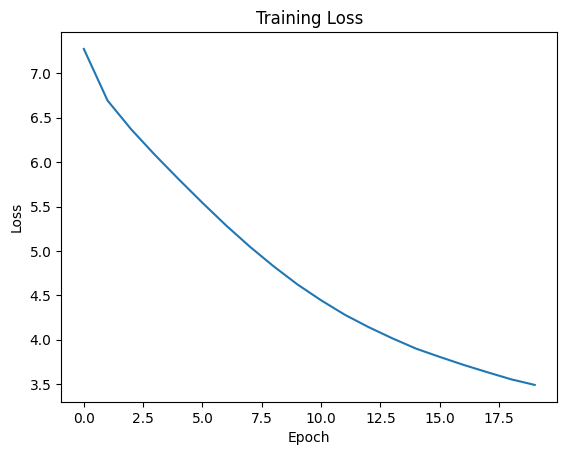

In [ ]:
# LSTM Text Generator using PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 1. Load and preprocess dataset
with open('input.txt', 'r') as f:
    text = f.read().lower()

# Tokenization
words = text.split()
word_counts = Counter(words)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
word2idx = {w: i+1 for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
total_words = len(word2idx) + 1

# Create sequences
sequences = []
seq_len = 5
for i in range(seq_len, len(words)):
    seq = words[i-seq_len:i+1]
    sequences.append([word2idx[w] for w in seq])

sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TextDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 2. Build the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
        return x

model = LSTMModel(total_words, 100, 128)

# 3. Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 20
losses = []

for epoch in range(epochs):
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(dataloader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# 4. Generate text
def generate_text(seed_text, next_words):
    model.eval()
    words_seq = seed_text.lower().split()
    for _ in range(next_words):
        tokenized = [word2idx.get(w, 0) for w in words_seq[-seq_len:]]
        input_seq = torch.tensor([tokenized], dtype=torch.long)
        with torch.no_grad():
            output = model(input_seq)
            predicted_idx = torch.argmax(output, dim=1).item()
            words_seq.append(idx2word.get(predicted_idx, ''))
    return ' '.join(words_seq)

# 5. Try generating
print(generate_text("the sun", 20))

# 6. Plot loss
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
